In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from models.transLOB import TransLOB
from utils.preprocessing import create_windows, generate_labels, normalize_features
from utils.training import train, validate
from utils.loader import LOBDataset

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
DATA_PATH = './data/crypto/BTC_1sec.csv'

BATCH_SIZE = 64
LEARNING_RATE = 1e-3
WINDOW_SIZE = 100
HORIZONS=[10, 20, 30, 50, 100]
TARGET_HORIZON = 'y_30'

In [4]:
data_df = pd.read_csv(DATA_PATH, index_col=0)
data_df = data_df[:500000]
data_df['system_time'] = pd.to_datetime(data_df['system_time'])
data_df

,system_time,midpoint,spread,buys,sells,bids_distance_0,bids_distance_1,bids_distance_2,bids_distance_3,bids_distance_4,...,asks_market_notional_5,asks_market_notional_6,asks_market_notional_7,asks_market_notional_8,asks_market_notional_9,asks_market_notional_10,asks_market_notional_11,asks_market_notional_12,asks_market_notional_13,asks_market_notional_14
0,2021-04-07 11:32:42.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,-0.000288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-04-07 11:32:43.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,-0.000288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-04-07 11:32:44.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,-0.000288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-04-07 11:32:45.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,-0.000288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-04-07 11:32:46.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,-0.000288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,2021-04-13 06:27:33.123831+00:00,61299.985,0.01,10171.524505,11063.704756,-8.156609e-08,-2.446983e-07,-0.000023,-0.000082,-0.000182,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
499996,2021-04-13 06:27:34.123831+00:00,61299.985,0.01,0.000000,502.512716,-8.156609e-08,-2.446983e-07,-0.000023,-0.000082,-0.000171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
499997,2021-04-13 06:27:35.123831+00:00,61299.985,0.01,5794.497412,185.870121,-8.156609e-08,-2.446983e-07,-0.000023,-0.000082,-0.000164,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
499998,2021-04-13 06:27:36.123831+00:00,61299.985,0.01,100.289849,502.512716,-8.156609e-08,-2.446983e-07,-0.000023,-0.000082,-0.000123,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
meta_features = ['system_time', 'midpoint', 'spread', 'buys', 'sells']
distance_features = [col for col in data_df.columns if "distance" in col]
notional_features = [col for col in data_df.columns if "bids_notional" in col or "asks_notional" in col]
cancel_notional_features = [col for col in data_df.columns if "cancel_notional" in col]
limit_notional_features = [col for col in data_df.columns if "limit_notional" in col]
market_notional_features = [col for col in data_df.columns if "market_notional" in col]

In [6]:
data_df = data_df[meta_features + distance_features + notional_features]
data_df = generate_labels(data_df, HORIZONS, alpha=1e-4)
data_df = normalize_features(data_df)
data_df

,system_time,midpoint,spread,buys,sells,bids_distance_0,bids_distance_1,bids_distance_2,bids_distance_3,bids_distance_4,...,asks_notional_10,asks_notional_11,asks_notional_12,asks_notional_13,asks_notional_14,y_10,y_20,y_30,y_50,y_100
0,2021-04-07 11:32:42.122161+00:00,56035.995,0.01,0.000000,0.000000,-2.271907e-06,-0.000055,-0.014871,-0.072758,-0.085299,...,0.029732,0.000012,0.000012,0.007253,0.002161,1,2,2,2,2
1,2021-04-07 11:32:43.122161+00:00,56035.995,0.01,0.000000,0.000000,-2.271907e-06,-0.000055,-0.014871,-0.072758,-0.085299,...,0.029732,0.000012,0.000012,0.007253,0.002161,1,2,2,2,2
2,2021-04-07 11:32:44.122161+00:00,56035.995,0.01,0.000000,0.000000,-2.271907e-06,-0.000055,-0.014871,-0.072758,-0.085299,...,0.029732,0.000012,0.000012,0.007253,0.002161,1,2,2,2,2
3,2021-04-07 11:32:45.122161+00:00,56035.995,0.01,0.000000,0.000000,-2.271907e-06,-0.000055,-0.014871,-0.072758,-0.085299,...,0.029732,0.000012,0.000012,0.007253,0.002161,1,2,2,2,2
4,2021-04-07 11:32:46.122161+00:00,56035.995,0.01,0.000000,0.000000,-2.271907e-06,-0.000055,-0.014871,-0.072758,-0.085299,...,0.029732,0.000012,0.000012,0.007253,0.002161,1,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,2021-04-13 06:27:33.123831+00:00,61299.985,0.01,10171.524505,11063.704756,-2.106797e-12,-0.000048,-0.006772,-0.024185,-0.053980,...,0.002160,0.000256,0.000007,0.000013,0.000009,1,1,1,1,1
499996,2021-04-13 06:27:34.123831+00:00,61299.985,0.01,0.000000,502.512716,-2.106797e-12,-0.000048,-0.006772,-0.024185,-0.050740,...,0.002160,0.000256,0.000482,0.000007,0.000013,1,1,1,1,1
499997,2021-04-13 06:27:35.123831+00:00,61299.985,0.01,5794.497412,185.870121,-2.106797e-12,-0.000048,-0.006772,-0.024185,-0.048708,...,0.002160,0.000256,0.000007,0.000013,0.000009,1,1,1,1,1
499998,2021-04-13 06:27:36.123831+00:00,61299.985,0.01,100.289849,502.512716,-2.106797e-12,-0.000048,-0.006772,-0.024185,-0.036326,...,0.002160,0.000256,0.000007,0.000013,0.000009,1,1,1,1,1


In [7]:
X = data_df
X['bid0']= X['midpoint']*(1+X['bids_distance_0'])
X['ask0']= X['midpoint']*(1+X['asks_distance_0'])
X['test']=(X['ask0']-X['midpoint'])/X['midpoint']
X[['midpoint','bid0','ask0','test']]

,midpoint,bid0,ask0,test
0,56035.995,56035.867691,56036.122309,2.271907e-06
1,56035.995,56035.867691,56036.122309,2.271907e-06
2,56035.995,56035.867691,56036.122309,2.271907e-06
3,56035.995,56035.867691,56036.122309,2.271907e-06
4,56035.995,56035.867691,56036.122309,2.271907e-06
...,...,...,...,...
499995,61299.985,61299.985000,61299.985000,2.106705e-12
499996,61299.985,61299.985000,61299.985000,2.106705e-12
499997,61299.985,61299.985000,61299.985000,2.106705e-12
499998,61299.985,61299.985000,61299.985000,2.106705e-12


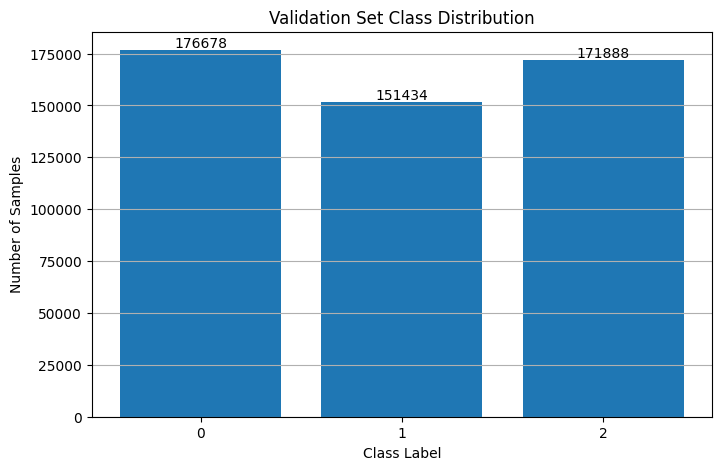

In [8]:
y_val_labels = np.array(data_df[TARGET_HORIZON])
class_counts = np.bincount(y_val_labels)

class_labels = [0, 1, 2]

plt.figure(figsize=(8,5))
plt.bar(class_labels, class_counts)

plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Validation Set Class Distribution')
plt.xticks(class_labels)
plt.grid(axis='y')

for i, count in enumerate(class_counts):
    plt.text(i, count + 5, str(count), ha='center', va='bottom')

plt.show()


In [9]:
feature_cols = [col for col in data_df.columns if col not in meta_features and not col.startswith('y_')]

X = data_df[feature_cols].values
y = data_df[TARGET_HORIZON].values

X.shape, y.shape

((500000, 63), (500000,))

In [10]:
X_windows, y_labels = create_windows(X, y, WINDOW_SIZE)
X_windows.shape

(499900, 100, 63)

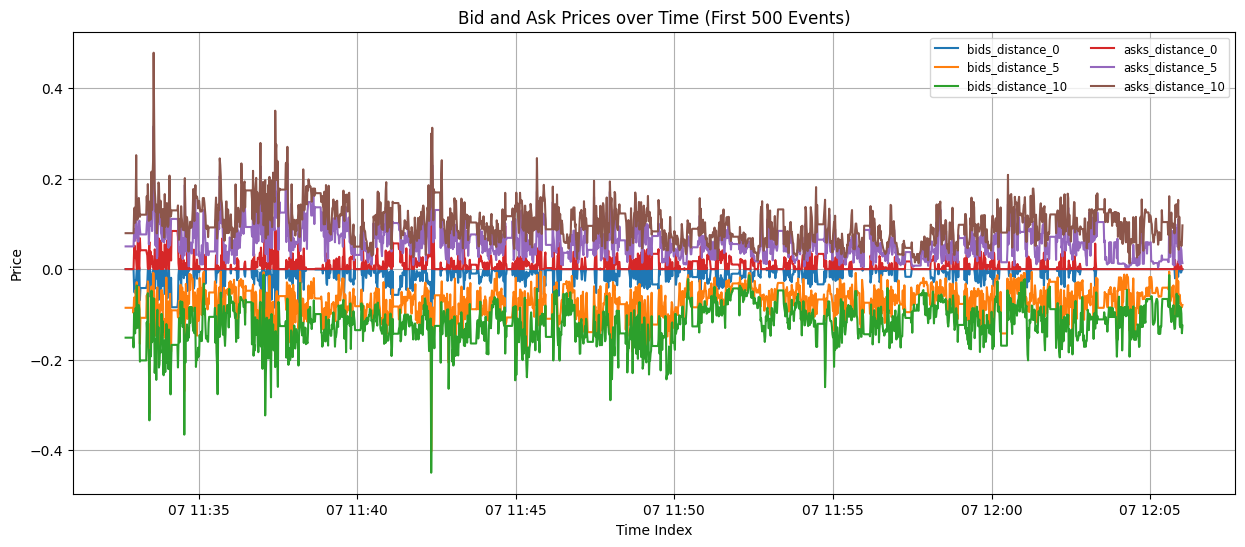

In [11]:
bid_price_cols = ['bids_distance_0','bids_distance_5','bids_distance_10']
ask_price_cols = ['asks_distance_0','asks_distance_5','asks_distance_10']

plot_range = 2000

plt.figure(figsize=(15, 6))

# Plot bids
for col in bid_price_cols:
    plt.plot(data_df['system_time'][:plot_range], data_df[col].values[:plot_range], label=col)#, color='blue', alpha=0.5)

# Plot asks
for col in ask_price_cols:
    plt.plot(data_df['system_time'][:plot_range], data_df[col].values[:plot_range], label=col)#, color='red', alpha=0.5)

plt.title('Bid and Ask Prices over Time (First 500 Events)')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.grid()
plt.show()

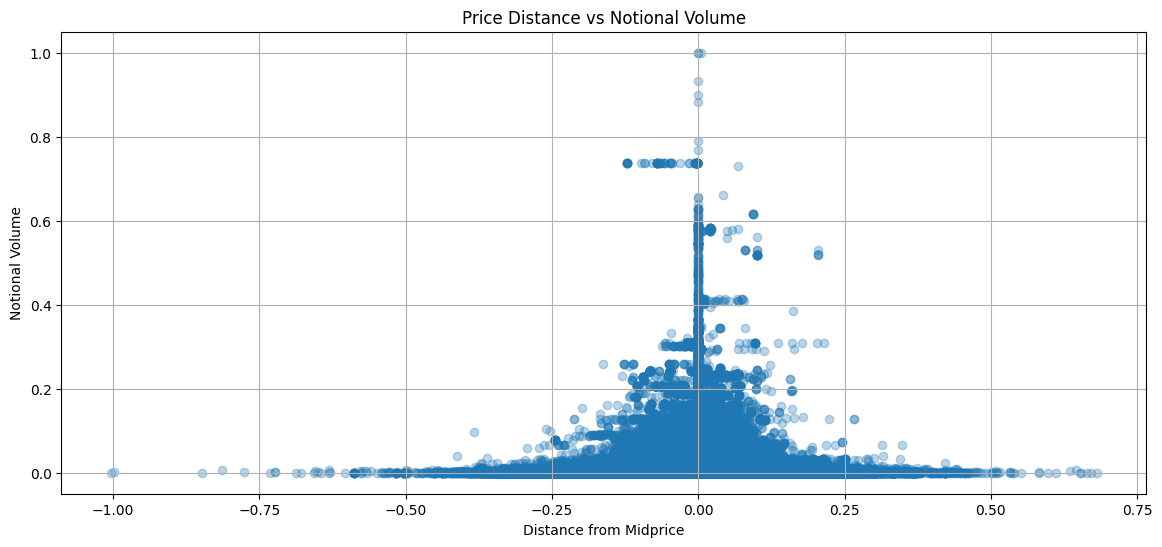

In [12]:
distances = data_df[distance_features].melt(var_name="distance_level", value_name="distance_value")
notionals = data_df[notional_features].melt(var_name="notional_level", value_name="notional_value")

combined = pd.DataFrame({
    "distance": distances["distance_value"],
    "notional": notionals["notional_value"]
})

plt.figure(figsize=(14, 6))
plt.scatter(combined["distance"], combined["notional"], alpha=0.3)
plt.xlabel('Distance from Midprice')
plt.ylabel('Notional Volume')
plt.title('Price Distance vs Notional Volume')
plt.grid(True)
plt.show()

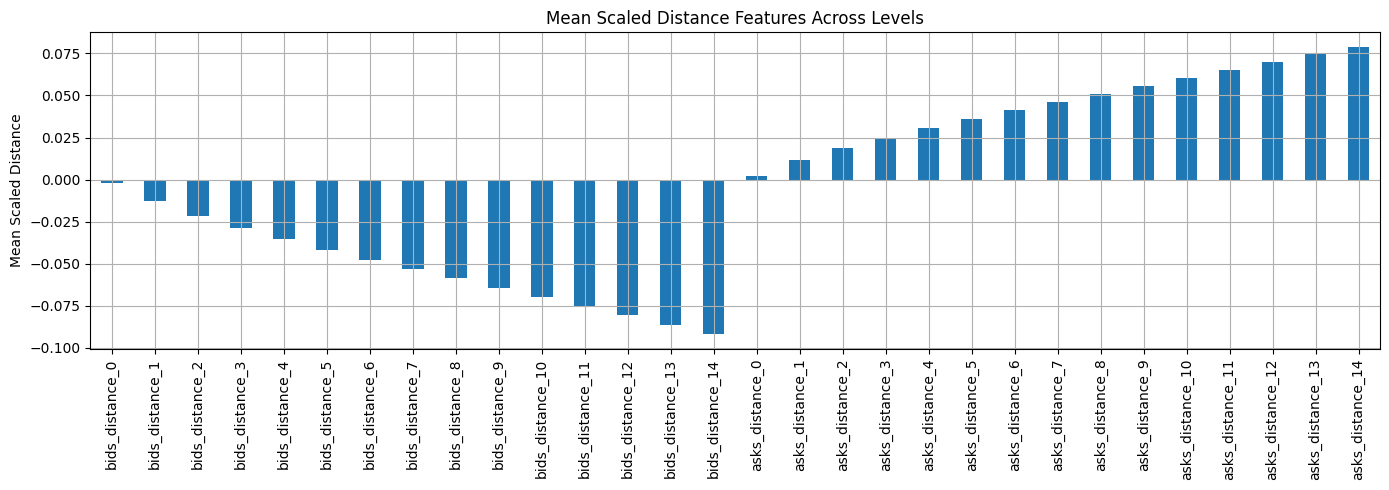

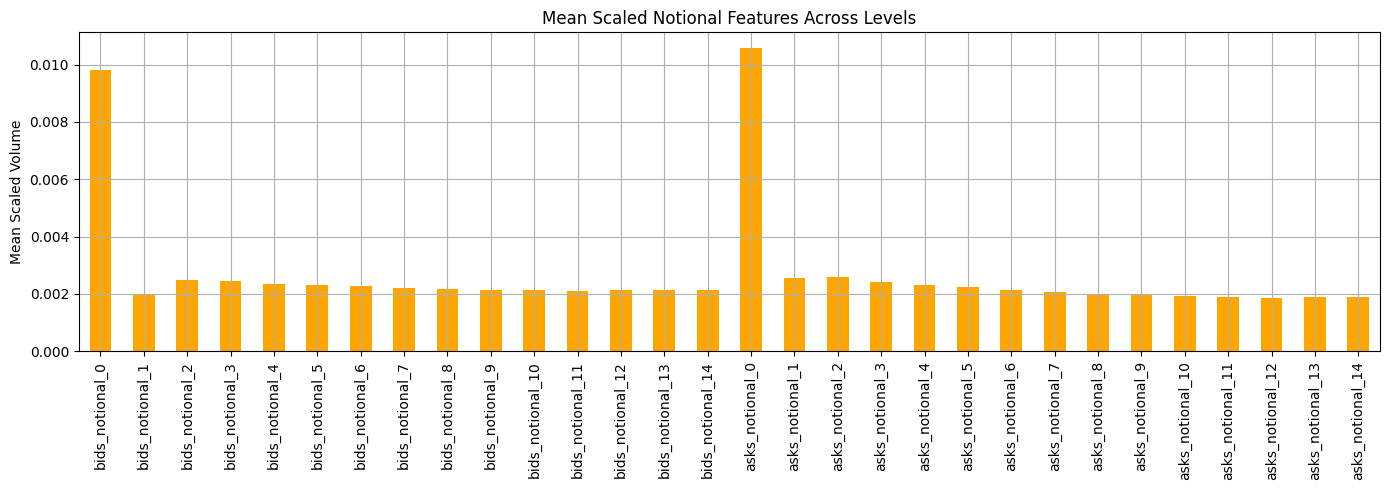

In [13]:
# Plot mean distance values across levels
plt.figure(figsize=(14, 5))
data_df[distance_features].mean().plot(kind='bar', title='Mean Scaled Distance Features Across Levels')
plt.ylabel('Mean Scaled Distance')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot mean notional values across levels
plt.figure(figsize=(14, 5))
data_df[notional_features].mean().plot(kind='bar', color='orange', title='Mean Scaled Notional Features Across Levels')
plt.ylabel('Mean Scaled Volume')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

## TransLOB

In [14]:
# Now splitting Train/Validation/Test chronologically
train_size = int(0.8 * len(X_windows))
val_size = int(0.2 * len(X_windows))

X_train, y_train = X_windows[:train_size], y_labels[:train_size]
X_val, y_val = X_windows[train_size:train_size+val_size], y_labels[train_size:train_size+val_size]
# X_test, y_test = X_windows[train_size+val_size:], y_labels[train_size+val_size:]

print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Validation shape: {X_val.shape}, {y_val.shape}")
# print(f"Test shape: {X_test.shape}, {y_test.shape}")

Train shape: (399920, 100, 63), (399920,)
Validation shape: (99980, 100, 63), (99980,)


In [15]:
train_dataset = LOBDataset(X_train, y_train)
val_dataset = LOBDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [16]:
model = TransLOB(
    num_features=len(feature_cols),
    num_classes=3,
    hidden_channels=14,
    d_model=64,
    num_heads=4,
    num_transformer_blocks=2
).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [17]:
train_losses = []
val_losses = []
val_accuracies = []

epochs = 5
best_val_acc = 0

for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}: Train Loss {train_loss:.4f} | Val Loss {val_loss:.4f} | Val Acc {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), './outputs/transLOB/best_model.pth')
        print(f"✅ Saved best model at epoch {epoch+1} with Val Acc {val_acc:.4f}")


[Batch 0/6249] Train Loss: 1.1340
[Batch 50/6249] Train Loss: 1.1083
[Batch 100/6249] Train Loss: 1.0780
[Batch 150/6249] Train Loss: 1.0957
[Batch 200/6249] Train Loss: 1.1002
[Batch 250/6249] Train Loss: 1.0870
[Batch 300/6249] Train Loss: 1.0894
[Batch 350/6249] Train Loss: 1.0970
[Batch 400/6249] Train Loss: 1.0946
[Batch 450/6249] Train Loss: 1.0981
[Batch 500/6249] Train Loss: 1.0896
[Batch 550/6249] Train Loss: 1.1004
[Batch 600/6249] Train Loss: 1.0984
[Batch 650/6249] Train Loss: 1.1041
[Batch 700/6249] Train Loss: 1.1113
[Batch 750/6249] Train Loss: 1.0970
[Batch 800/6249] Train Loss: 1.0998
[Batch 850/6249] Train Loss: 1.0981
[Batch 900/6249] Train Loss: 1.0964
[Batch 950/6249] Train Loss: 1.0965
[Batch 1000/6249] Train Loss: 1.0958
[Batch 1050/6249] Train Loss: 1.1071
[Batch 1100/6249] Train Loss: 1.1056
[Batch 1150/6249] Train Loss: 1.1050
[Batch 1200/6249] Train Loss: 1.0933
[Batch 1250/6249] Train Loss: 1.0794
[Batch 1300/6249] Train Loss: 1.1023
[Batch 1350/6249] Train 

KeyboardInterrupt: 

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()

plt.plot(val_accuracies, label='Val Accuracy')
plt.legend()
plt.show()

In [ ]:
model.eval()

X_sample_batch, y_true_batch = next(iter(val_loader))
X_sample_batch, y_true_batch = X_sample_batch.to(device), y_true_batch.to(device)

with torch.no_grad():
    outputs = model(X_sample_batch)
    _, y_pred_batch = outputs.max(1)

# Move back to CPU for easy viewing
y_true_batch = y_true_batch.cpu().numpy()
y_pred_batch = y_pred_batch.cpu().numpy()

# Compare true vs predicted
for i in range(10):  # first 10 examples
    print(f"Sample {i}: True label = {y_true_batch[i]}, Predicted = {y_pred_batch[i]}")


In [ ]:
correct = 0
total = 0

model.eval()
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = outputs.max(1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

manual_val_acc = correct / total
print(f"Manual Validation Accuracy: {manual_val_acc:.4f}")

In [ ]:
y_val_labels = np.array(y_val)
print("Class counts:", np.bincount(y_val_labels))

In [ ]:
cm = confusion_matrix(y_true_batch, y_pred_batch)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()